## Data <a class="anchor" id="first-bullet"></a>
Lets have a look at a few samples from our dataset

In [66]:
names = [street.rstrip() for street in open("../data/streets_zh.txt")] #.rstrip() removes new line character '\n'
names[:5]

['Aargauerstrasse',
 'Abeggweg',
 'Abendweg',
 'Ackermannstrasse',
 'Ackersteinstrasse']

## Exact modelling - Count, count, count! <a class="anchor" id="second-bullet"></a>

As we mentioned earlier, we're going to build our street name model by looking at individual characters, specifically pairs of characters (known as *bigrams*). For our first model, we're going to count the number of times each bigram appears in our dataset.

Let's take a look at an example. The first street name in our dataset is 'Aargauerstrasse'. Let's split it into its bigrams

In [67]:
for name in names[:1]:
    for pair in zip(name, name[1:]):
        print(pair)

('A', 'a')
('a', 'r')
('r', 'g')
('g', 'a')
('a', 'u')
('u', 'e')
('e', 'r')
('r', 's')
('s', 't')
('t', 'r')
('r', 'a')
('a', 's')
('s', 's')
('s', 'e')


In this case all our bigrams are unique, but if we iterate through all the street names and keep track of the bigrams we encounter, we find

In [68]:
letters = set() # keep track of all the unique characters
pairs = set() # keep track of all the unique pairs 
count_pairs = dict() 

for name in names:
    for pair in zip(name, name[1:]):
        letters.add(pair[0])
        pairs.add(pair)
        count_pairs[pair] = 1 + count_pairs.get(pair, 0)     

In [69]:
list(count_pairs.items())[:14] # print 14 first examples from our dictionary

[(('A', 'a'), 1),
 (('a', 'r'), 112),
 (('r', 'g'), 129),
 (('g', 'a'), 169),
 (('a', 'u'), 109),
 (('u', 'e'), 25),
 (('e', 'r'), 629),
 (('r', 's'), 221),
 (('s', 't'), 1181),
 (('t', 'r'), 1110),
 (('r', 'a'), 1189),
 (('a', 's'), 1309),
 (('s', 's'), 1359),
 (('s', 'e'), 1366)]

And if we sort by the most common bigrams

In [70]:
sorted(list(count_pairs.items()), key=lambda entry: -entry[1])[:14]

[(('s', 'e'), 1366),
 (('s', 's'), 1359),
 (('a', 's'), 1309),
 (('r', 'a'), 1189),
 (('s', 't'), 1181),
 (('t', 'r'), 1110),
 (('e', 'r'), 629),
 (('e', 'n'), 584),
 (('e', 'g'), 462),
 (('w', 'e'), 367),
 (('c', 'h'), 358),
 (('n', 's'), 289),
 (('t', 'e'), 262),
 (('e', 'i'), 224)]

It's no surprise that the most common bigrams in our dataset are those that appear in the word 'strasse' (which means 'street' in German).

There is one thing we are missing though. We don't know how often a name starts with a given character nor when it ends with one. This would be useful to know as it will help us to create more realistic names.  We can solve this with a simple trick: add a unique special character, say `"$"`, at the beginning and end of every street name such that `'Aargauerstrasse'` becomes `'$Aargauerstrasse$'`. We now assign this special character the meaning of start and end of a word. Even though we are talking about Zurich, `"$"` is not occuring in any of the original street names so indeed we are free to assign it this meaning without it causing any confusion ;) Furthermore, we are free to use the same special character to mark beginning *and* end because its position within a bigram uniquely identifies if it acts as a beginning or end marker:


In [71]:
for name in names[:1]:
    name = "$" + name + "$"
    for pair in zip(name, name[1:]):
        print(pair)

('$', 'A')
('A', 'a')
('a', 'r')
('r', 'g')
('g', 'a')
('a', 'u')
('u', 'e')
('e', 'r')
('r', 's')
('s', 't')
('t', 'r')
('r', 'a')
('a', 's')
('s', 's')
('s', 'e')
('e', '$')


Back to the bigram counts. To make things a bit more practical for us, let us express the counts as probabilities. For this we  restructure our dictionary `count_pairs` into a lookup table `freq_per_char` where every entry `freq_per_char[c_i][c_j]` corresponds to how often the character `c_i` was followed by the character `c_j`. We then can go from counts to probabilties by normalizing every row in this table such that every row adds up to 1.

In [72]:
# rerun the code from above with "$"s
names = ['$'+street.rstrip()+'$' for street in open("../data/streets_zh.txt")] #.rstrip() removes new line character '\n'
count_pairs = dict() 

for name in names:
    for pair in zip(name, name[1:]):
        letters.add(pair[0])
        pairs.add(pair)
        count_pairs[pair] = 1 + count_pairs.get(pair, 0)

# build our lookup table
freq_per_char = {c: dict() for c in letters}
for pair, frequency in count_pairs.items():
    first, second = pair
    freq_per_char[first][second] = frequency

# normalize rows
for k in freq_per_char.keys():
    total = sum(list(freq_per_char[k].values()))
    for v in freq_per_char[k]:
        freq_per_char[k][v]/= total

Lets visualize this lookup table

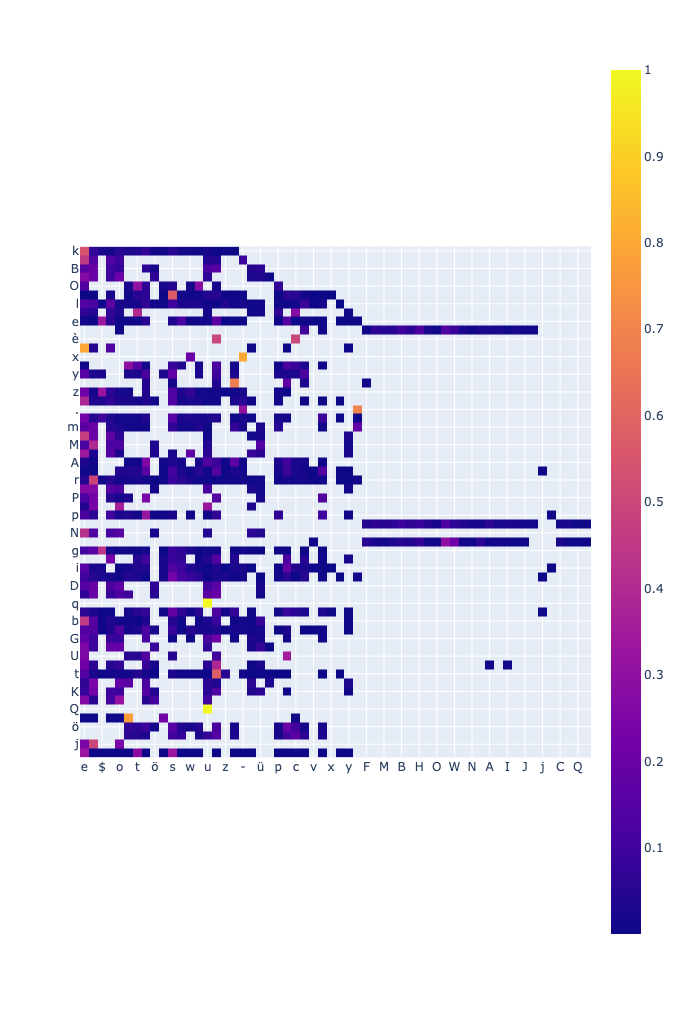

In [24]:
import plotly.express as px
import pandas as pd

px.imshow(pd.DataFrame.from_dict(freq_per_char).T, width=1024, height=1024)

This gives us a nice and pretty overview! Also an opportunity for us to check if things look like we expect them to do. For example, we see that the `"$"` is only followed by capital letters, which makes sense. 

We are now ready to generate new street names 🥁! We can do this by iteratively adding new characters to the starting string `"$"`. At each step, we'll use the last character we added to the string to determine the probability distribution of the next character via our lookup table. We'll keep adding new characters until we reach the "$" character again, giving us a new Zurich street name! Let see how this plays out...

In [16]:
from random import choices
n_samples = 20

for _ in range(n_samples):
    gen = ["$"]
    while True:
        c = gen[-1]
        samples = list(freq_per_char[c].keys())
        p_samples = list(freq_per_char[c].values())
        next_c = choices(samples, p_samples)[0]
        gen.append(next_c)
        if next_c=="$":
            break
    print("".join(gen))

$Strurasste$
$Horasse$
$Spösstrastrtrastreisenn$
$Jurge$
$Amm Haseg$
$Scktrweranwalingaselssstz$
$Wasstraldbasssmbegntotelz-Strassstrastingsssckeg$
$Gasstrasserühbrasssststthaselzin-Le$
$Nose$
$Küsenwe$
$Kälohse$
$Im-Plwe-Cassernebe$
$Bub-Pachachieratraste$
$Gracheggludepe$
$Asstrsetrüsee$
$Frassssenserckloblgssegateranastradseiwendsseisserzwe Rog$
$Silen$
$Heie$
$Cobünme$
$Frange$


I hope you are not too disappointed😔. The results indeed seem a bit underwhelming ... However, lets look at what the names would look like if we would sample every next letter with equal probability

In [25]:
from random import choices
n_samples = 20

for _ in range(n_samples):
    gen = ["$"]
    while True:
        c = gen[-1]
        #samples = list(freq_per_char[c].keys())
        #p_samples = list(freq_per_char[c].values())
        #next_c = choices(samples, p_samples)[0]
        next_c = choices(list(letters))[0]
        gen.append(next_c)
        if next_c=="$":
            break
    print("".join(gen))

$dD SäGqw LPcxS èVhSPèlEKUTcuJvxuSAuAZzUNG.èljL$
$dqPNnösRBfGjCeObJHKc VtdFUzBwHg U$
$AMMqJNsIoMNzoBaOSDe$
$üNoqZèVWr.üKuWyvWRpaääKjN-cAkQöxqNEwdctbllVsuJöNqüFABäCTqHiihSTS fRHZbqmaT JqèSAzAAqZFpVICCtZnqèPjJBwGETPkxZEDiZEkzOrHFCGAIeKgäpGxeümmBtTNHhvgDmgrAüxZKäönMzpIZèr$
$DSGpö$
$TPoäatVv-üu-GltnMWeRHHLsöDnHLExCAjnTèVPrlCx-KkZwHifmumozKQäpüäpOFCxhaqiEA.vUetäVRNhlFèfraCEröh.$
$l-KPtCUxKBäUoW.AmHxmzkSQ-PäqüfuHeyktkxsiKwxöüekäBUxoKxjRNiFGLgG.urlFocüJAlgsTQgeLgdzüAbuäfmSääfCOrCvrmR AwNbSoèaöRQ-PFGhBjäUAèDKSfwGJhf.nSedGxwdtUeeZoZuskOqR-x.RknubCWrU$
$ècnd èFèbMSDQRWjäiGNeFyäMamIEMiZRbTfAzENxyIüiPABGjjFaOnxMRhwIJGeJhèl.KtKna.orILäèz.uPuSnZZFk$
$GpixPhnkyEjZoTVWvhdIkSeSèZtäLD.ügPnvRzSoeJgèAtPöps-kIEdhuTCäxsJpnm$
$L.r.NuääHwLEUliopd -BFi-hvhamrO.kZyGzApNBCJzlWmNCAIpLdPDmtdcwEHEoKIHzpzP$
$I-Fy.egLdI-JCKdJAlMS.-fUDVoVKJcBeojE-uK-PöJRfCäLNsgUcJsmüTeDNs-DmhMkIèaiOwoSeBqfslOüOysclenxkKvmoaybvb-njRHxUrO PcudFweaCHjbpGnuSVNfsThP.JHomAxMAWabbuybEktüwUFVdocöHpBDdrBcdFlxlgGL.OcVöp cZHDh-vqOgsü-D uVVZcObEu

Uiii!!! So we see that while our bigram model is not able to come up with super realistic street names, they are still way closer to real street names than this.

Why is our bigram model not performing better though? Turns out that only looking at the previous character to predict the next character is not enough to capture the "nature" of street names. We will extend our bigram model to n-gram models (i.e. look at the previous $n-1$ characters to predict the next character) further below. For now, lets stick with bigrams though. 

As announced, we are going to build the same model using a simple neural network in the next part. Before we do that, however, we will need to clarify what we mean by "same" model. How can we compare different models if they have been constructed in totally different ways? It turns out that looking at the probabilities for every pair and multipliying them together is a measure of how well the model predicts the dataset. In the next section we explore and motviate this in more detail, however, feel free to skip it if you are not interested in the technical details.